<h1> Predict Future Sales - Exploratory Data Analysis </h1>


In this notebook, I am going to explore all of the features of the Predict Future Sales competition dataset.

By doing this, I hope to help those who just got into this competition understand this dataset, get some feature engineering ideas, and hopefully build upon my work.

**Here's what I am going to cover:**
<li>What are the trend and seasonal ccomponents of the time series data</li>
<li>How the multiple variables of this competition dataset relate with each other</li>
<li>Useful feature engineering ideas</li>
<li>And much more</li>


If this is your first time working with time series data, I recommend that you also take some time to explore my code, since extracting information from time series data is more complex than usual.

And without further ado, let's get started:

<h2> Importing Libraries & Getting to Know the Dataset </h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Display all columns of a pandas DataFrame to help us visualize the entire dataset
pd.set_option('display.max_columns',None)

Now, in the original competition dataset, all of the item names, categories, and shops are in Russian. And if you don't know a single word of Russian just like most of us, extracting insights from the text features is next to impossible.

Thankfully, [@deepdivelm](https://www.kaggle.com/deepdivelm) went through the trouble of translating everything to English and uploading it for all of us to use. So instead of using the original CSV files provided in the competition, we will use the translated version, this way we can easily analyze the structure of the text data and squeeze useful information from it.

In [2]:
item_categories = pd.read_csv('../input/predict-future-sales-eng-translation/categories.csv')
item_categories.head(12)

,category_name,category_id
0,PC - Headsets / Headphones,0
1,Accessories - PS2,1
2,Accessories - PS3,2
3,Accessories - PS4,3
4,Accessories - PSP,4
5,Accessories - PSVita,5
6,Accessories - XBOX 360,6
7,Accessories - XBOX ONE,7
8,Tickets (Digital),8
9,Delivery of goods,9


As you can see, the names that what comes before the hyphen are general category names, meanwhile what comes after it seems to be subcategory names.

So we can easily engineer some features from this text data...

In [3]:
items = pd.read_csv('../input/predict-future-sales-eng-translation/items.csv').rename({'category_id':'item_category_id'},axis=1)
items.head(5)

,item_id,item_category_id,item_name
0,0,40,!! IN THE POWER OF HAPPINESS (PLAST) D
1,1,76,! ABBYY FineReader 12 Professional Edition Ful...
2,2,40,*** IN THE GLORY OF THE GLORY (UNV) D
3,3,40,*** BLUE WAVE (Univ) D
4,4,40,*** BOX (GLASS) D


Now, extracting information from this particular table seems next to impossible.

Some discussion threads argued that the item name length holds important information for our model, since similar items have similar name lengths...

So if you are curious to know if this feature can indeed help your model, you can easily test this hypothesis by creating a new feature.

In [4]:
shops = pd.read_csv('../input/predict-future-sales-eng-translation/shops.csv')
shops.head(12)

,shop_name,shop_id
0,"! Yakutsk Ordzhonikidze, 56 francs",0
1,"! Yakutsk TC ""Central"" fran",1
2,"Adygea TC ""Mega""",2
3,"Balashikha TC ""Oktyabr-Kinomir""",3
4,"Volga TC ""Volga Mall""",4
5,"Vologda SEC ""Marmelad""",5
6,"Voronezh (Plekhanovskaya, 13)",6
7,"Voronezh SEC ""Maksimir""",7
8,"Voronezh SEC City-Park ""Grad""",8
9,Outbound Trade,9


Curiously enough, the shops table is full of information.

Starting with the first word of the shop_name column, which seems to be the city a particular shop is located.

Meanwhile, the second word of the column seems to be the type of the store (For example, multiple stores have SEC as their second word, and others have TC, and so on...)

---

<h3> Train and Test Sets </h3>


Now, let's take some time to explore the train and test sets provided to us.

In [5]:
train = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
train.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')
test.head(5)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


What immediately comes to attention is that the train dataset has multiple features, such as the <i>item price</i> feature and the <i>number of sales per day</i> feature, whereas the test dataset only has the <i>shop id</i> and the <i>item id</i> of the month we are trying to predict.

So whatever model we create later on has to somehow capture the interplay between these two variables.

<h2> Exploratory Data Analysis </h2>

Our train data goes back 33 months before the period that we are trying to predict, so let's see how the number of sales has behaved throughout this time period.

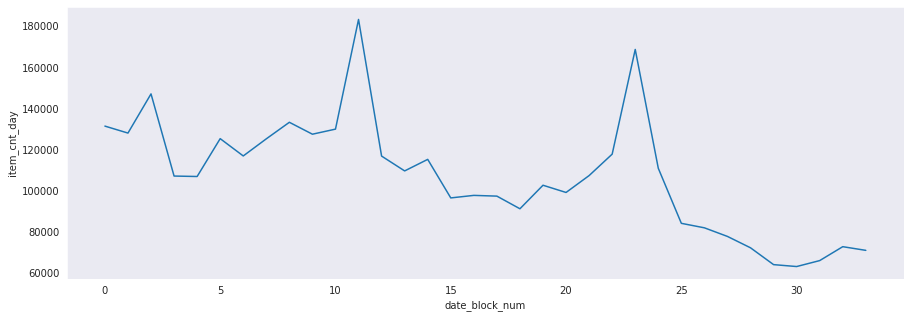

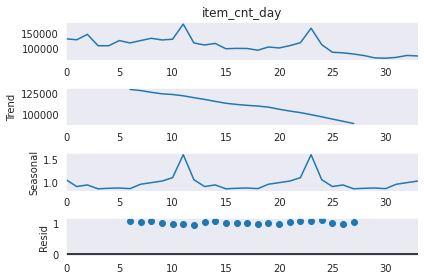

In [7]:
sales_per_month = train.groupby(by='date_block_num')['item_cnt_day'].sum()
plt.figure(figsize=(15,5))
sns.set_style('dark')
sns.lineplot(data=sales_per_month)

decomposition = sm.tsa.seasonal_decompose(sales_per_month,period=12,model='multiplicative')
decomposition.plot();

As you can see, the number of sales is trending downward, but every 12 months we see a big spike in sales. (Black Friday comes to mind)

Needless to say, it is very important for our model to capture these time-related dynamics.

Another important information we have to figure out is to see how the number of sales correlates with itself by using the autocorrelation and partial autocorrelation coefficients (you can learn more about these coefficients - which are very useful when analysing time-series - [here](https://otexts.com/fpp3/acf.html))

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


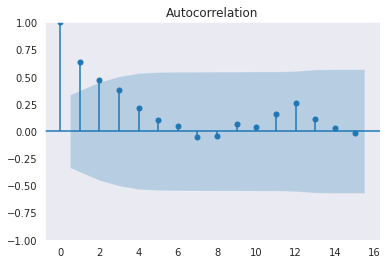

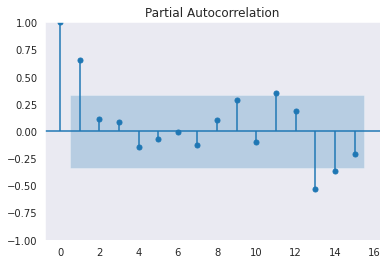

In [8]:
plot_acf(sales_per_month,lags=15);
plot_pacf(sales_per_month,lags=15);

According to the autocorrelation plot, the number of sales for the very next month is closely related to the number of sales in the current month. However, as our timeframe gets broader, the autocorrelation coefficient gets closer and closer to zero.

Of course, this is to be expected, and these graphics will help us find out what should be the ideal timeframes of the lagged and rolling features we will create later on for our model.

---

<h3> Revenue Per Month </h3>

Since our dataset also stores the price of sale of a given item, let's also analyze the revenue per month of all items and see what kind of patterns we can find.

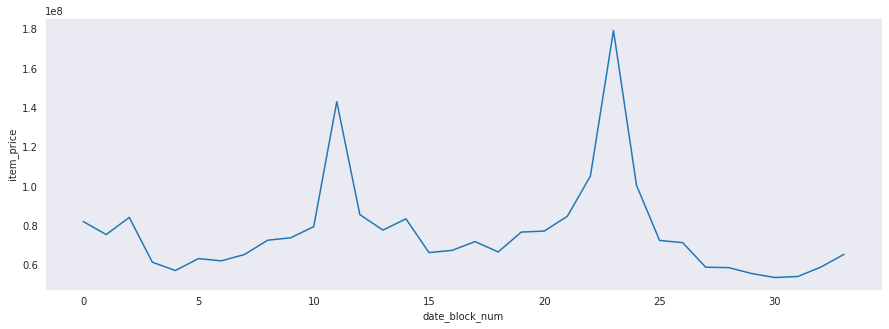

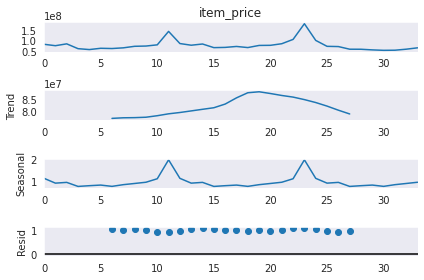

In [9]:
#
plt.figure(figsize=(15,5))
revenue_per_month = train.groupby(by='date_block_num')['item_price'].sum()
sns.lineplot(data=revenue_per_month)

#
decompose = sm.tsa.seasonal_decompose(revenue_per_month,period=12,model='multiplicative')
decompose.plot();

Just as with the number of sales features, we see that the revenue per month spikes every 12 months. However, the trend seems to be slightly different from the one we observed before.

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


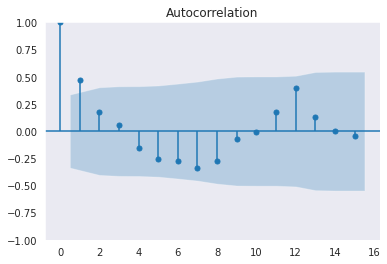

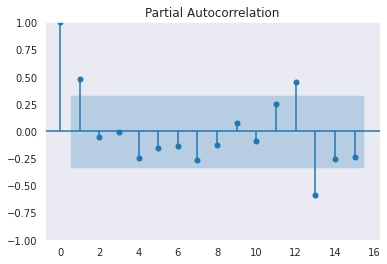

In [10]:
plot_acf(revenue_per_month,lags=15);
plot_pacf(revenue_per_month,lags=15);

Curiously enough, this feature seems to be way less autocorrelated and therefore seems to be less predictive than then the number of sales feature.


---

<h2> Shop Analysis </h2>

Now, let's also break down our analysis by <i>Shop IDs</i> to see which ones make the most amount of sales and also how revenue is distributed among them.

Text(0, 0.5, 'Total Sales')

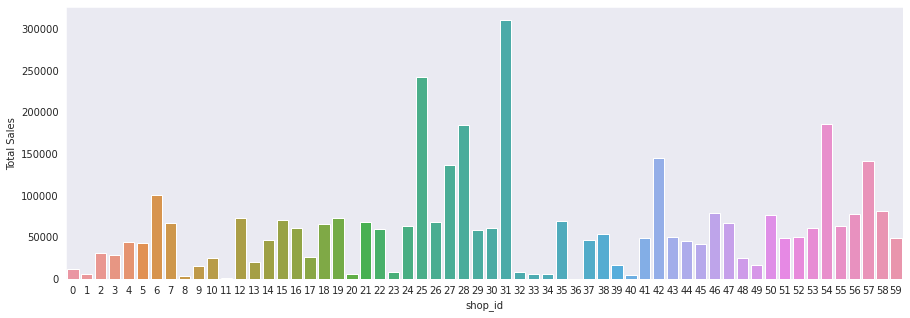

In [11]:
sales_per_shop = train.groupby(by='shop_id')['item_cnt_day'].sum().reset_index()
plt.figure(figsize=(15,5))
sns.barplot(data=sales_per_shop,x='shop_id',y='item_cnt_day')
plt.ylabel('Total Sales')

Text(0, 0.5, 'Total Shops')

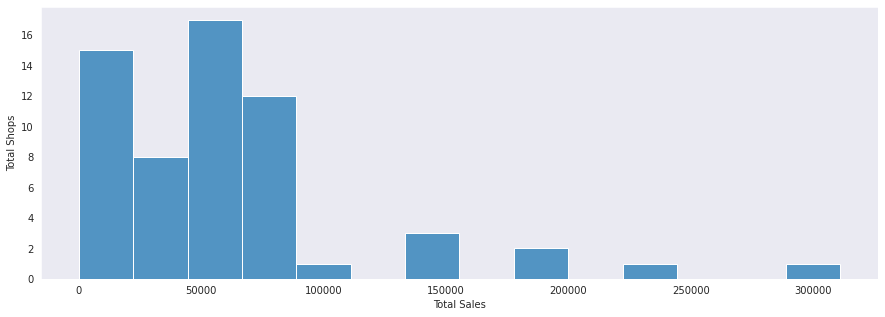

In [12]:
plt.figure(figsize=(15,5))
sns.histplot(data=sales_per_shop,x='item_cnt_day')
plt.xlabel('Total Sales')
plt.ylabel('Total Shops')

As you can see, the amount of sales per shop is unevenly distributed... While some shops barely made sales in the 33 months time period of our dataset, other shops made thousands of sales.

Maybe that has something to do with the ticket of the item sold by each one of these stores, so let's take some time to analyze these relationships...

<AxesSubplot:xlabel='shop_id', ylabel='item_price'>

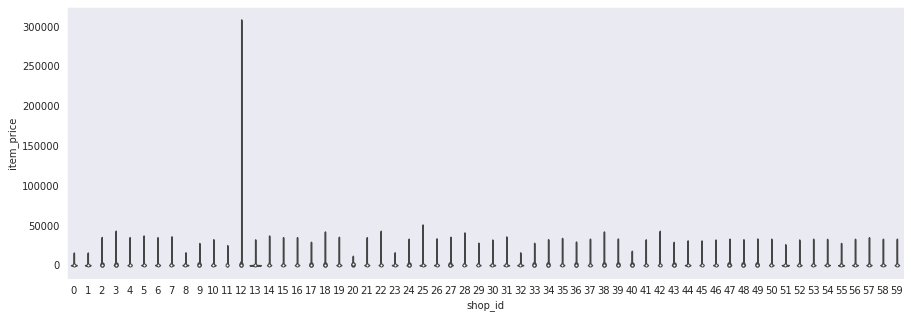

In [13]:
plt.figure(figsize=(15,5))
shop_x_price = train[['shop_id','item_price']]
sns.violinplot(data=shop_x_price,x='shop_id',y='item_price')

In [ ]:
print(sales_per_item)

: 

As you can see, most (except for one outlier) of these shops sell items in the same price range.

With that in mind, let's also find out how sales are distributed by item id.

In [14]:
sales_per_item = train.groupby(by='item_id')['item_cnt_day'].sum().reset_index()
for percentage, sales in sales_per_item['item_cnt_day'].quantile([0.25,0.5,0.75,1]).iteritems():
    print(str(percentage*100)+f'% of the stores have sold less than {sales} units \n')
#plt.figure(figsize=(15,5))
#sns.kdeplot(data=sales_per_item,x='item_cnt_day',cut=0,alpha=1,fill=True)

25.0% of the stores have sold less than 7.0 units 

50.0% of the stores have sold less than 33.0 units 

75.0% of the stores have sold less than 124.0 units 

100.0% of the stores have sold less than 187642.0 units 



As you can see, most items haven't sold more than 33 units on the analyzed timeframe, while others have sold hundreds of thousands of units, which means this metric is highly skewed. 

For now, let's also see the distribution of item prices and how it relates to the number of sales.

25.0% of the items are sold for less than $249.0 

50.0% of the items are sold for less than $399.0 

75.0% of the items are sold for less than $999.0 

100.0% of the items are sold for less than $307980.0 



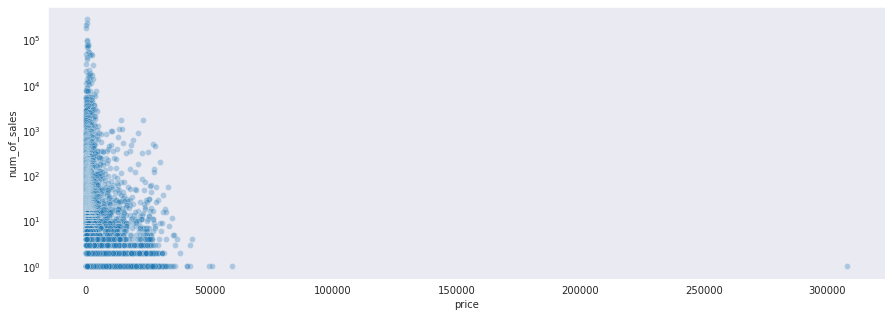

In [15]:
for percentage, price in train['item_price'].quantile([0.25,0.5,0.75,1]).iteritems():
    print(str(percentage*100)+f'% of the items are sold for less than ${price} \n')

#
#plt.figure(figsize=(15,5))
#sns.kdeplot(data=train,x='item_price',cut=0,fill=True,alpha=1)


#
plt.figure(figsize=(15,5))
sales_x_price = train['item_price'].value_counts().reset_index().rename({'index':'price','item_price':'num_of_sales'},axis=1)
sns.scatterplot(data=sales_x_price,x='price',y='num_of_sales',alpha=0.3).set_yscale('log')

As you can see, most products are sold for less than $400, and on top of that, there seems to be a clear relationship with the item price and its number of sales in the analysed timeframe, with the number of sales being inversely correlated with the price of a given item.

So whatever model we build later on has to capture this relationship somehow.


---

<h3> Category </h3>

Now, let's also analyze how a given product category influences its amount of sales.

Text(0, 0.5, 'Total Sales')

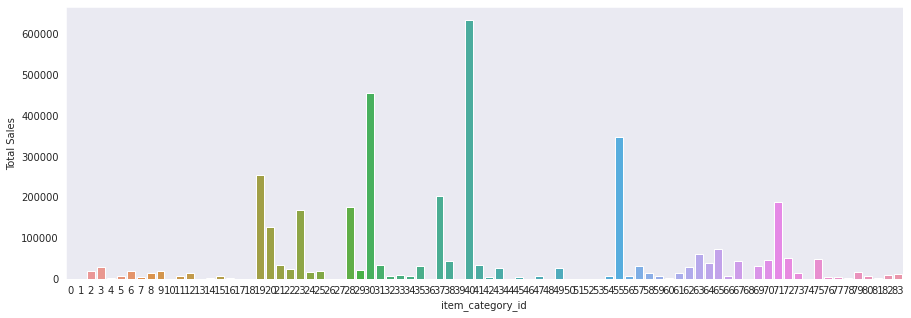

In [16]:
plt.figure(figsize=(15,5))
sales_per_category = pd.DataFrame(train.merge(items,how='left',on='item_id').groupby(by=['item_category_id'])['item_cnt_day'].sum().reset_index())
sns.barplot(data=sales_per_category,x='item_category_id',y='item_cnt_day')
plt.ylabel('Total Sales')

Text(0, 0.5, 'Total Categories')

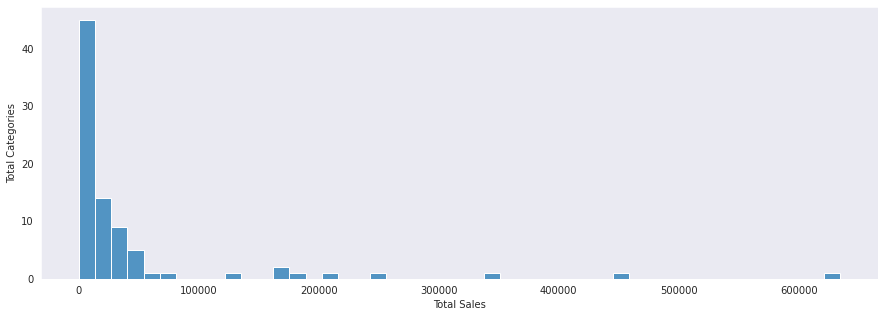

In [17]:
plt.figure(figsize=(15,5))
sns.histplot(data=sales_per_category,x='item_cnt_day')
plt.xlabel('Total Sales')
plt.ylabel('Total Categories')

As you can see, the distribution of sales per category is highly skewed.

While some categories barely made sales in the 33 months of this dataset, others have made hundreds of thousands, so I am sure this information is useful for our prediction model.

NOw, could this high skewness be the result of a sizeable difference in item prices? Let's see...

<AxesSubplot:xlabel='item_category_id', ylabel='item_price'>

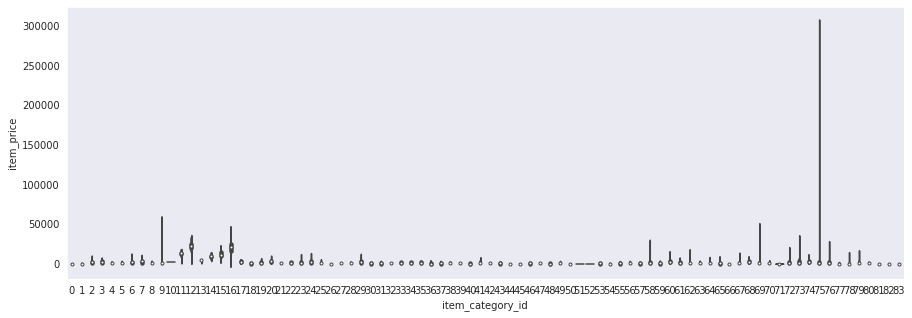

In [18]:
plt.figure(figsize=(15,5))
category_x_price = pd.DataFrame(train.merge(items,how='left',on='item_id'))[['item_category_id','item_price']]
sns.violinplot(data=category_x_price,x='item_category_id',y='item_price')

Category prices are all across the board, while some categories only have small ticket items, some only have high ticket items and others have evertyhing in between.


---

<h3> Revenue X Sales </h3>

Now, multiplying sales by the amount revenue is potentially a great way to capture the interplay between these two variables. So with that in mind, so let's analyze how this features behaves and if this hypothesis makes sense.

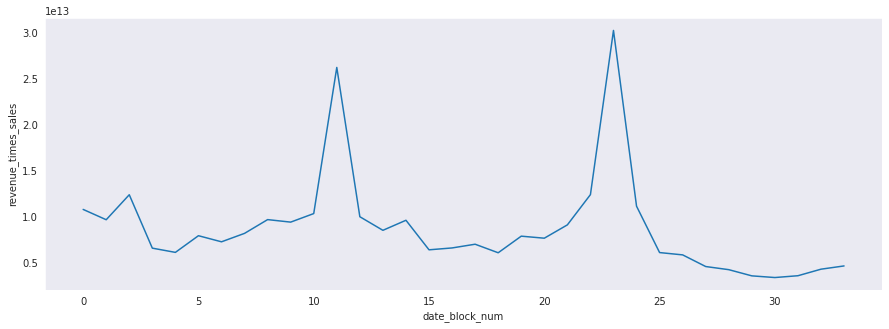

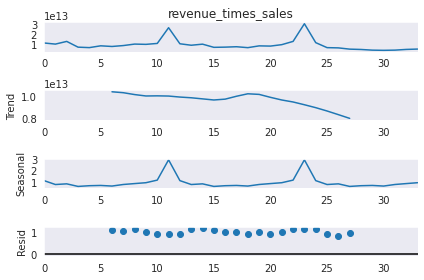

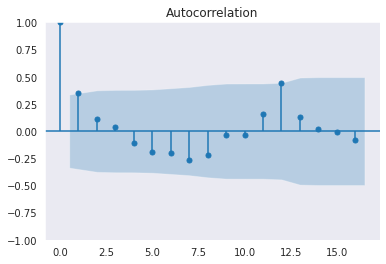

In [19]:
plt.figure(figsize=(15,5))
rev_times_sales_df = train[train['item_cnt_day'] >= 0].groupby(by='date_block_num')[['item_price','item_cnt_day']].sum()
rev_times_sales_df['revenue_times_sales'] = rev_times_sales_df['item_price']*rev_times_sales_df['item_cnt_day']
rev_times_sales_df.reset_index()
sns.lineplot(data=rev_times_sales_df,x='date_block_num',y='revenue_times_sales')
decompose = sm.tsa.seasonal_decompose(rev_times_sales_df['revenue_times_sales'],period=12,model='multiplicative')
decompose.plot();
plot_acf(rev_times_sales_df['revenue_times_sales']);

As you can see, the seasonal component is still the same as all the other features we have analyzed so far, with spikes every 12 months.

Whereas the downward trend is a little smoother than the other ones.

However, the autocorrelation coefficient is abysmal, so this feature is probably not as useful as we first imagined and will only add noise to the model.

---

<h2> Closing Remarks </h2>

By now you have a clear understanding of the entire dataset and how its variables behave, so hopefully, you can start creating your own features and building a highly predictive model.

If you got some more insights from the data that you think I missed, feel free to comment them in the discussion section and I will add them to this notebook.

And if this notebook got you thinking about lots of ideas, feel free to fork it and build upon it.

Thanks for reading and good luck in the competition.